In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
import sklearn
from sklearn import pipeline, preprocessing, feature_extraction
import xgboost as xgb
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, auc, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from scipy import sparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/fao3864/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
1

In [ ]:
1+1

In [2]:
X_train = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")

y_train = pd.DataFrame(X_train['is_duplicate'])
y_train.columns = ['y']
del X_train['is_duplicate']

skf = StratifiedKFold(5, shuffle=True, random_state=0)
folds = []
for itr, ite in skf.split(X_train, y_train.y):
    folds += [[itr, ite]]

In [3]:
from nltk.corpus import stopwords

df_train = pd.read_csv("data/train.csv")

stops = set(stopwords.words("english"))

train_qs = pd.Series(X_train['question1'].tolist() + X_train['question2'].tolist()).astype(str)
test_qs = pd.Series(X_test['question1'].tolist() + X_test['question2'].tolist()).astype(str)

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}


def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

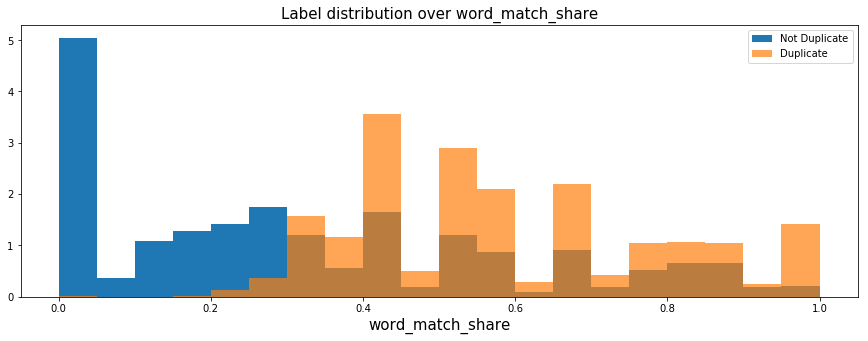

In [4]:
plt.figure(figsize=(15, 5))

train_word_match = df_train.apply(word_match_share, axis=1, raw=True)

plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in double_scalars


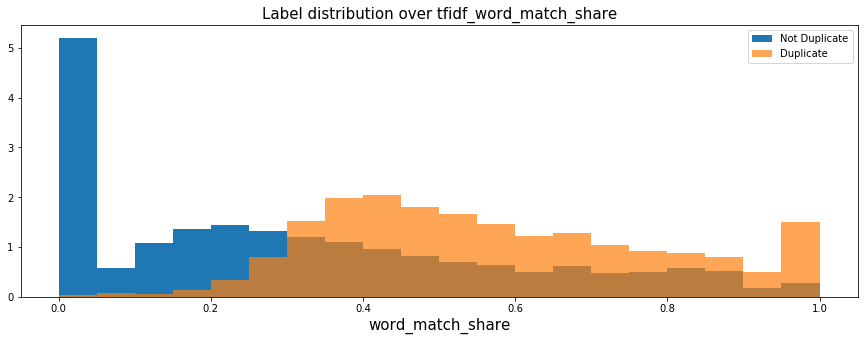

In [5]:
plt.figure(figsize=(15, 5))

tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)

plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [6]:
X_train['question1'] = X_train['question1'].apply(lambda x: str(x))
X_train['question2'] = X_train['question2'].apply(lambda x: str(x))
X_test['question1'] = X_test['question1'].apply(lambda x: str(x))
X_test['question2'] = X_test['question2'].apply(lambda x: str(x))

X_train['question1'] = X_train['question1'].apply(lambda x: x.lower().split())
X_train['question2'] = X_train['question2'].apply(lambda x: x.lower().split())
X_test['question1'] = X_test['question1'].apply(lambda x: x.lower().split())
X_test['question2'] = X_test['question2'].apply(lambda x: x.lower().split())

In [7]:
X = map(lambda x: ' '.join(x), X_train['question1'])
X1 = map(lambda x: ' '.join(x), X_train['question2'])
Y = map(lambda x: ' '.join(x), X_test['question1'])
Y1 = map(lambda x: ' '.join(x), X_test['question2'])

hw = HashingVectorizer(n_features=200).fit(X_train['question1'] + X_train['question2'])


In [8]:
X = pd.DataFrame(hw.transform(X).todense())
X1 = pd.DataFrame(hw.transform(X1).todense())
Y = pd.DataFrame(hw.transform(Y).todense())
Y1 = pd.DataFrame(hw.transform(Y1).todense())

In [9]:
tfidf = feature_extraction.text.TfidfTransformer()
tfidf.fit(X+X1)

X = pd.DataFrame(tfidf.transform(X).todense())
X1 = pd.DataFrame(tfidf.transform(X1).todense())
Y = pd.DataFrame(tfidf.transform(Y).todense())
Y1 = pd.DataFrame(tfidf.transform(Y1).todense())

In [10]:


X_train = pd.concat([X_train, X], axis=1, join_axes=[X_train.index])
del X
X_train = pd.concat([X_train, X1], axis=1, join_axes=[X_train.index])
del X1
X_test = pd.concat([X_test, Y], axis=1, join_axes=[X_test.index])
del Y
X_test = pd.concat([X_test, Y1], axis=1, join_axes=[X_test.index])
del Y1

In [11]:
X_train[:2]

,id,qid1,qid2,question1,question2,word_match,tfidf_word_match,0,1,2,...,190,191,192,193,194,195,196,197,198,199
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0.727273,0.772164,0.0,0.0,0.0,...,0.0,0.0,0.325385,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4,"[what, is, the, story, of, kohinoor, (koh-i-no...","[what, would, happen, if, the, indian, governm...",0.307692,0.361758,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X_train['word_match'] = X_train.apply(word_match_share, axis=1, raw=True)
print(1)
X_train['tfidf_word_match'] = X_train.apply(tfidf_word_match_share, axis=1, raw=True)
print(2)
X_test['word_match'] = X_test.apply(word_match_share, axis=1, raw=True)
print(3)
X_test['tfidf_word_match'] = X_test.apply(tfidf_word_match_share, axis=1, raw=True)

1


/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in double_scalars


2
3


/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in long_scalars


In [12]:
del X_train['question1']
del X_train['question2']
del X_train['qid1']
del X_train['qid2']
del X_train['id']

del X_test['question1']
del X_test['question2']
del X_test['test_id']

In [ ]:
1

In [27]:
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'logloss'
param['max_depth'] = 5
# param['booster'] = 'dart'
#param['booster'] = 'gblinear'
param['eta'] = 0.3
#param['subsample'] = 1.0
# param["scale_pos_weight"] = 0.5
#param['colsample_bytree'] = 0.7
param['nthread'] = 8
#param['num_class'] =3
#param['alpha'] = 0.00
#param['lambda_bias'] = 0.1
# param['lambda'] = 0
#param['min_child_weight'] = 100

# if param['booster'] == 'gblinear': param['eta'] *= 1e-4
numround = 500

#LGBM
params = {
    #'task': 'train',
    #'boosting_type': 'gbdt',
    #'objective': 'regression',
    #'metric': {'l2', 'auc'},
    #'num_leaves': 31,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    #'subsample': 0.8,
    #'colsample_bytree': 0.7,
    'objective': 'binary',
    'nthread': -1,
    'learning_rate': 0.1,
    'min_child_weight': 50,
    #'max_depth': 6
    #'num_class': 3
    
}

pred_train = np.zeros(len(y_train))
xgbs = []
sc,sc_mean = [],[]

for itr, ite in folds:
    ypred = []
    for i in range(1):
               
        param['seed'] = i+1
        '''
        #xgboost
        
        Xdatatrain = xgb.DMatrix(data=X_train.ix[itr, :].values,
                                     label=y_train.ix[itr].values)
        Xdataval = xgb.DMatrix(data=X_train.ix[ite, :].values,
                                     label=y_train.ix[ite].values)

        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdataval, 'eval')]
        bst = xgb.train(plst, Xdatatrain, numround, evals=watchlist, verbose_eval=20)

        
        #rc = ensemble.ExtraTreesClassifier(n_estimators=1300, criterion='gini', max_depth=None, n_jobs=-1)
        #pred_train[ite] = bst.predict(Xdataval)
        #neigh = KNeighborsClassifier(n_neighbors=2)
        #neigh.fit(X_train.ix[itr, :], y_train.ix[itr])
        ypred = bst.predict(Xdataval)
        #ypred = neigh.predict_proba(X_train.ix[ite, :])
        xgbs.append(bst)
        '''
        
        # train
        lgb = lgbm.sklearn.LGBMClassifier(n_estimators=300, seed=0, **params)
        lgb.fit(X_train.ix[itr, :], y_train.ix[itr])
        ypred = lgb.predict_proba(X_train.ix[ite, :])[:, 1]
        
        '''
        model.fit(X_train.ix[itr, :].values, y_train_cat[itr],
            epochs=60,
            batch_size=1000)
        ypred = model.predict(X_train.ix[ite, :].values)
        '''
    #ypred = sum(ypred) / len(ypred)
    pred_train[ite] = ypred
    
    sc.append(log_loss(y_train.ix[ite, :], pred_train[ite]))

    
print('XGB: {:.3f} +- {:.3f}'.format(np.mean(sc), np.std(sc)))

/home/fao3864/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fao3864/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fao3864/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fao3864/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

XGB: 0.401 +- 0.002


In [ ]:
0.386
0.481

In [16]:
pred_train = pd.DataFrame(pred_train)
pred_train.columns = ['y']
pred_train.to_csv("stacking/lgb_2.csv", index=None)

In [22]:
submit = pd.read_csv("data/sample_submission.csv")

In [23]:
lgb = lgbm.sklearn.LGBMClassifier(n_estimators=300, seed=0, **params)
lgb.fit(X_train, y_train)
test_pred = lgb.predict_proba(X_test)[:, 1]

/home/fao3864/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fao3864/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
submit['is_duplicate'] = test_pred

In [25]:
submit.to_csv("stacking/lgb_2_test.csv", index=None)